In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
SAMPLE_SHP_IN_DIR = 'data/Shapefile/GDFigure2/SampleArea.shp'
CENSUS_IN_DIR = 'data/GiveDirectly/Survey/GE_HH_Census_2017-07-17_cleanGPS.csv'

In [3]:
df = pd.read_csv(
    CENSUS_IN_DIR,
    usecols=['sublocation_code', 'village_code', 'ge', 'hi_sat', 'treat',
             'latitude', 'longitude', 'elevation', 'accuracy', 'eligible',
             'GPS_imputed', 'dist_from_vill'],
    dtype={
        'sublocation_code': 'Int64',
        'village_code': 'Int64',
        'ge': 'Int32',
        'hi_sat': 'Int32',
        'treat': 'Int32',
        'eligible': 'Int32',
        'GPS_imputed': 'Int32'})

In [4]:
# drop non GE households
df = df.loc[df['ge'] == 1, :]

In [5]:
# drop imputed GPS coords
df = df.loc[df['GPS_imputed'] == 0, :]

In [6]:
df.loc[:, 'treat_eligible'] = df.loc[:, 'treat'].values * df.loc[:, 'eligible'].values

In [7]:
min_lon = 34.040  # 34.044261
max_lon = 34.460  # 34.451611
min_lat = -0.055  # -0.050481
max_lat = 0.315  # 0.310766
step = 0.005

In [8]:
# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['longitude'].values - min_lon) / step) * step + min_lon
df.loc[:, 'grid_lat'] = np.round((df['latitude'].values - min_lat) / step) * step + min_lat

In [9]:
df_group = df.groupby(['grid_lon', 'grid_lat']).agg(
    treat_eligible=pd.NamedAgg(column='treat_eligible', aggfunc='sum'),
)

grid_lon, grid_lat = np.meshgrid(
    np.linspace(min_lon, max_lon, (max_lon - min_lon) / step + 1),
    np.linspace(min_lat, max_lat, (max_lat - min_lat) / step + 1))
grid_shape = grid_lon.shape

df_grid = pd.DataFrame({'grid_lon': grid_lon.flatten(), 'grid_lat': grid_lat.flatten()})

df_grid = pd.merge(df_grid, df_group, how='left', on=['grid_lon', 'grid_lat'])

df_grid.fillna(0, inplace=True)

In [10]:
raster = df_grid['treat_eligible'].values.astype(int).reshape(grid_shape)[::-1, :]

In [11]:
bound, = gpd.read_file(SAMPLE_SHP_IN_DIR)['geometry']

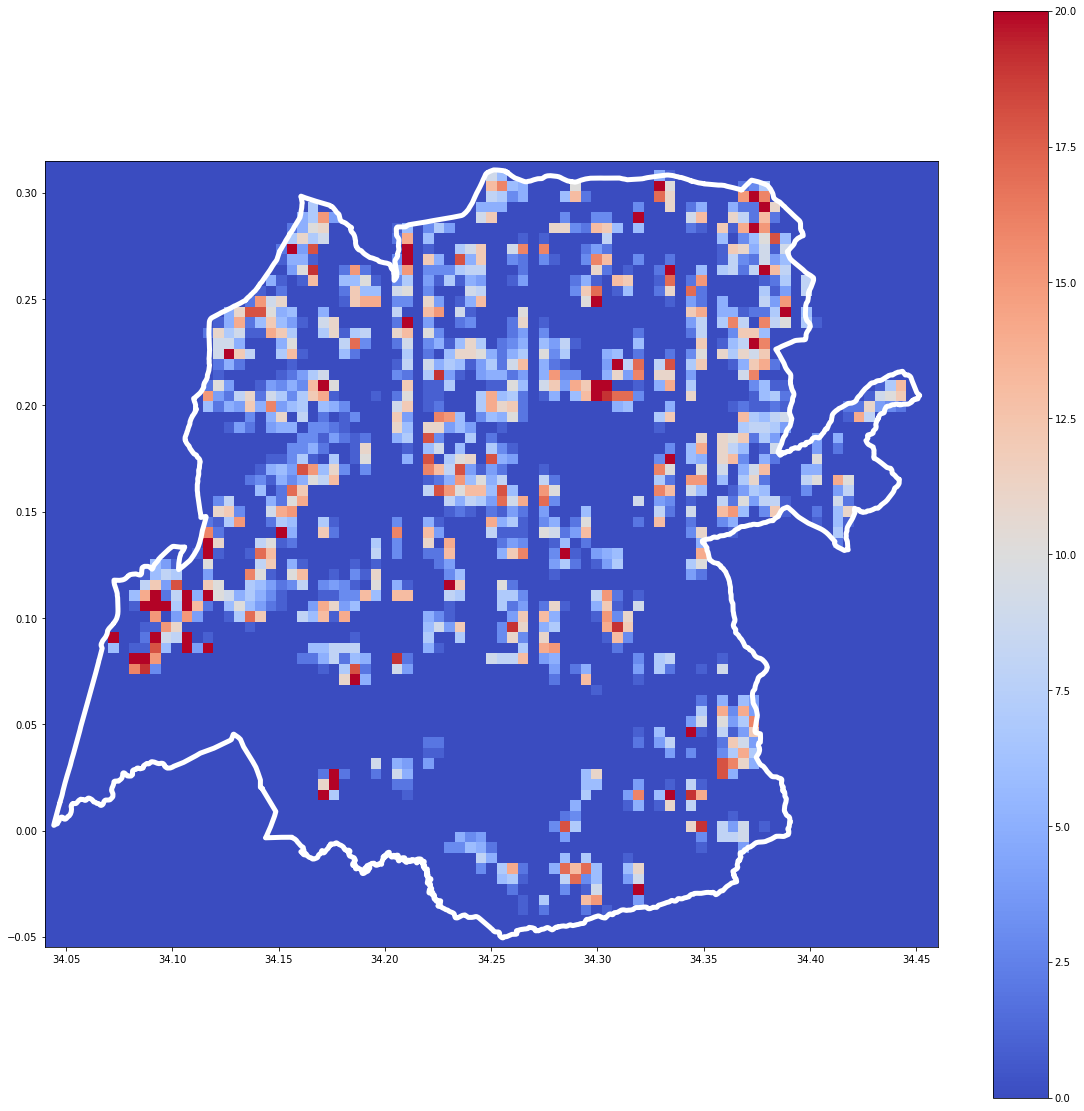

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(raster,
           extent=(min_lon, max_lon, min_lat, max_lat),
           vmax=20,
           cmap='coolwarm')
plt.plot(*bound.exterior.xy, color='white', linewidth=5)
plt.colorbar()
plt.show()